# CNV Analysis

In [1]:
import cPickle
import datetime
import glob
import os
import random
import re
import subprocess

import cdpybio as cpb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'cnv_analysis'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'lead_variants_single.tsv')
lead_vars_single = pd.read_table(fn, index_col=0)
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)

gene_bt = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'encode_dnase_overlap.tsv')
encode_dnase_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'encode_tf_chip_seq_overlap.tsv')
encode_chip_overlap = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'cnv_processing', 'roadmap_overlap.tsv')
roadmap_overlap = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'private_output', 'cnv_processing', 'emmax_cnvs.tsv')
emmax_cnvs = pd.read_table(fn, index_col=0)

In [3]:
cnv_lead_vars = lead_vars[lead_vars.variant_type == 'cnv']
cnv_lead_vars['cnv_id'] = cnv_lead_vars.marker_id.apply(lambda x: 'CNV' + x.split('CNV')[1])
cnv_gv = gene_variant[gene_variant.variant_type == 'cnv']
cnv_gv['cnv_id'] = cnv_gv.marker_id.apply(lambda x: 'CNV' + x.split('CNV')[1])

In [4]:
n = emmax_cnvs.shape[0]
print('{:,} distinct CNVs we could test'.format(n))
a = cnv_lead_vars.shape[0]
b = len(set(cnv_lead_vars.marker_id))
print('{} eQTLs with CNV as lead variant ({} distinct CNVs)'.format(a, b))
a = cnv_gv.shape[0]
b = len(set(cnv_gv.gene_id))
c = len(set(cnv_gv.marker_id))
print('{:,} gene-CNV associations for {} genes and {} CNVs'.format(a, b, c))

3,222 distinct CNVs we could test
158 eQTLs with CNV as lead variant (135 distinct CNVs)
1,043 gene-CNV associations for 306 genes and 524 CNVs


In [5]:
cnv_gv['cnv_is_lead'] = cnv_gv.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_is_lead'] = lead_vars.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_sig'] = lead_vars.gene_id.apply(lambda x: x in cnv_gv.gene_id.values)

In [6]:
a = len(set(gene_variant.gene_id))
b = len(set(gene_variant.ix[gene_variant.variant_type != 'cnv', 'gene_id']))
print('{} eGenes would have been missed if CNVs were not included'.format(a - b))

31 eGenes would have been missed if CNVs were not included


## GO enrichment

In [7]:
fn = os.path.join(outdir, 'go_results.tsv')
if not os.path.exists(fn):
    t = pd.Series(False, set(gene_variant.gene_id))
    t[set(cnv_gv.gene_id)] = True
    go_res = cpb.analysis.goseq_gene_enrichment(
        [x.split('.')[0] for x in t.index],
        t.values, 
        plot_fn=None, 
        length_correct=False)
    go_res.to_csv(fn, sep='\t')
else:
    go_res = pd.read_table(fn, index_col=0)

In [8]:
go_res[['over_represented_pvalue', 'term', 'over_represented_pvalue_bh']].head(10)

,over_represented_pvalue,term,over_represented_pvalue_bh
category,,,
GO:0003823,1.113045e-07,antigen binding,0.001524
GO:0042611,4.734736e-07,MHC protein complex,0.003240
GO:0023023,2.460643e-06,MHC protein complex binding,0.008420
GO:0023026,2.460643e-06,MHC class II protein complex binding,0.008420
GO:0042605,3.837480e-06,peptide antigen binding,0.010505
GO:0042613,1.046118e-05,MHC class II protein complex,0.023865
GO:0071556,1.449757e-05,integral component of lumenal side of endoplas...,0.024805
GO:0098553,1.449757e-05,lumenal side of endoplasmic reticulum membrane,0.024805
GO:0032395,2.003438e-05,MHC class II receptor activity,0.028917


## Effect sizes

TODO: I'd like to simplify the plot and stats tests below.

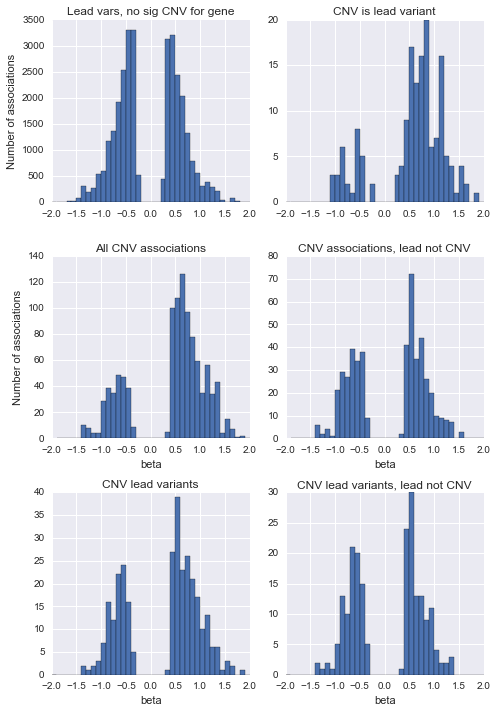

In [9]:
fig,axs = plt.subplots(3, 2, figsize=(7, 10))
ax = axs[0, 0]
lead_vars[lead_vars.cnv_sig == False].beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_title('Lead vars, no sig CNV for gene')
ax = axs[0, 1]
cnv_lead_vars.beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_title('CNV is lead variant')
ax = axs[1, 0]
cnv_gv.beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_ylabel('Number of associations')
ax.set_xlabel('beta')
ax.set_title('All CNV associations')
ax = axs[1, 1]
cnv_gv[cnv_gv.cnv_is_lead == False].beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV associations, lead not CNV')
ax = axs[2, 0]
cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta.hist(ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants')
ax = axs[2, 1]
cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta.hist(
    ax=ax, bins=np.arange(-2, 2.1, 0.1))
ax.set_xlim(-2, 2)
ax.set_xlabel('beta')
ax.set_title('CNV lead variants, lead not CNV')
plt.tight_layout()

In [54]:
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta.abs(),
                         cnv_lead_vars.beta.abs())
s,p

(1436577.5, 3.3888102029798705e-20)

In [10]:
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_lead_vars.beta)
print('Effect size for lead variants for eGenes with no lead CNV vs. '
      'lead CNVs for eGenes with lead CNV: p={:.2e}'.format(p))
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.beta)
print('Effect size for lead variants for eGenes with no lead CNV vs. '
      'all sig. CNVs for eGenes with sig CNV: p={:.2e}'.format(p))
s,p = stats.mannwhitneyu(cnv_gv[cnv_gv.cnv_is_lead == False].beta,
                         cnv_gv.beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv.sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)
s,p = stats.mannwhitneyu(lead_vars[lead_vars.cnv_sig == False].beta,
                         cnv_gv[cnv_gv.cnv_is_lead == False].sort_values('pvalue').drop_duplicates('gene_id').beta)
print(p)

Effect size for lead variants for eGenes with no lead CNV vs. lead CNVs for eGenes with lead CNV: p=1.20e-26
Effect size for lead variants for eGenes with no lead CNV vs. all sig. CNVs for eGenes with sig CNV: p=1.32e-93
4.90050044004e-14
1.18355333345e-12
0.0511360573928


## Properties

In [11]:
s = '\n'.join(cnv_info.chrom + '\t' + cnv_info.start.astype(str) + 
              '\t' + cnv_info.end.astype(str) + '\t' + cnv_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()

res = cnv_bt.intersect(gene_bt, sorted=True, wo=True)
df = res.to_dataframe()
overlaps_gene = set(df.name)

cnv_gv['cnv_gene'] = cnv_gv.cnv_id + ':' + cnv_gv.gene_id
t = pd.DataFrame(True, index=df.name + ':' + df.thickEnd, columns=['cnv_overlaps_gene'])
cnv_gv = cnv_gv.merge(t, left_on='cnv_gene', right_index=True, how='left')
cnv_gv.ix[cnv_gv.cnv_overlaps_gene.isnull(), 'cnv_overlaps_gene'] = False

In [12]:
sig_cnvs = set(cnv_gv.cnv_id)
not_sig_cnvs = set(emmax_cnvs.index) - sig_cnvs

### Length

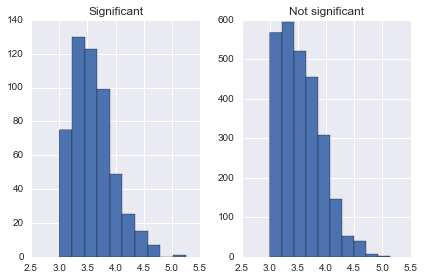

In [13]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(cnv_info.ix[sig_cnvs, 'length']).hist(ax=ax)
ax.set_title('Significant')
ax = axs[1]
np.log10(cnv_info.ix[not_sig_cnvs, 'length']).hist()
ax.set_title('Not significant');
plt.tight_layout()

In [14]:
s,p = stats.mannwhitneyu(cnv_info.ix[sig_cnvs, 'length'], 
                         cnv_info.ix[not_sig_cnvs, 'length'])
print('CNVs with significant associations are longer than those without '
      'significant associations: p = {:.2e}'.format(p))

CNVs with significant associations are longer than those without significant associations: p = 2.46e-03


### Distance to nearest TSS

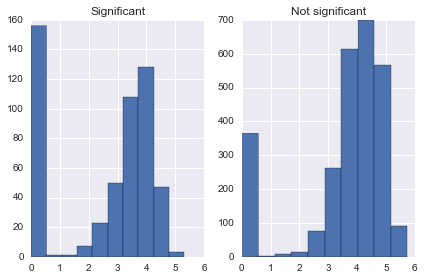

In [15]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(cnv_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist(ax=ax)
ax.set_title('Significant')
ax = axs[1]
np.log10(cnv_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1).hist()
ax.set_title('Not significant');
plt.tight_layout()

We can see that significant CNVs are typically closer to a TSS than CNVs
that are not signficant.

In [16]:
a = cnv_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
a = a[a != 0]
b = cnv_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print('CNVs with significant associations are closer to a TSS than those without '
      'significant associations: p = {:.2e}'.format(p))

CNVs with significant associations are closer to a TSS than those without significant associations: p = 1.75e-41


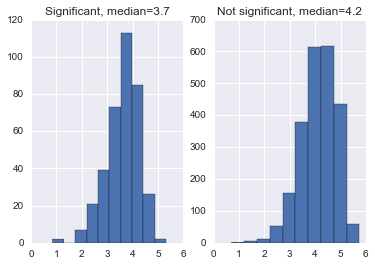

In [17]:
fig,axs = plt.subplots(1, 2)
ax = axs[0]
np.log10(a.abs()).hist(ax=ax)
ax.set_title('Significant, median={:.1f}'.format(np.log10(a.abs()).median()))
ax = axs[1]
ax.set_title('Not significant, median={:.1f}'.format(np.log10(b.abs()).median()))
np.log10(b.abs()).hist(ax=ax);

In [19]:
a = cnv_info.ix[sig_cnvs - set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'cnv_id']), 'nearest_tss_dist'].abs()
a = a[a != 0]
b = cnv_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
b = b[b != 0]
s,p = stats.mannwhitneyu(a, b)
print('Removing all CNVs that overlap any gene, CNVs with significant '
      'associations are closer to a TSS than those without '
      'significant associations: p = {:.2e}'.format(p))

Removing all CNVs that overlap any gene, CNVs with significant associations are closer to a TSS than those without significant associations: p = 4.78e-33


Even if we remove CNVs that overlap genes, the significant
CNVs are still closer to genes.

### Gene overlap

In [20]:
overlaps_sig = len(sig_cnvs & overlaps_gene)
overlaps_not_sig = len(not_sig_cnvs & overlaps_gene)
no_overlaps_sig = len(sig_cnvs) - overlaps_sig
no_overlaps_not_sig = len(not_sig_cnvs) - overlaps_not_sig
ctable = [[overlaps_sig, overlaps_not_sig], 
          [no_overlaps_sig, no_overlaps_not_sig]]
odds,p = stats.fisher_exact(ctable)
print('CNVs with significant association are enriched for '
      'overlapping a gene p={:.1e}'.format(p))

CNVs with significant association are enriched for overlapping a gene p=5.4e-20


## Intergenic CNV eQTLs

I'm going to look at CNV-eQTLs where the CNV doesn't overlap the affected gene.

In [21]:
s = set(cnv_gv.ix[cnv_gv.cnv_overlaps_gene, 'gene_id'])
intergenic_cnv_gv = cnv_gv[cnv_gv.gene_id.apply(lambda x: x not in s)]

sig_intergenic_cnvs = set(intergenic_cnv_gv.cnv_id)
not_sig_cnvs = set(emmax_cnvs.index) - set(cnv_gv.cnv_id)

In [22]:
promoters = pbt.BedTool('/publicdata/gencode_v19_20151104/promoters_by_gene.bed')
df = promoters.to_dataframe()
df['gene'] = df.name.apply(lambda x: x.split('_')[0])
df['region'] = df.name.apply(lambda x: x.split('_')[2])
df.index = df.region
gb = df.groupby('gene')
gene_to_promoters = gb.groups

In [23]:
def get_hic_interactions(cnv, gene):
    # CNV location
    chrom,start,end = cnv_info.ix[cnv, ['chrom', 'start', 'end']].values
    r = '{}:{}-{}'.format(chrom, start, end)
    fn = ('/projects/CARDIPS/pipeline/Hi-C/7_indv_HiC/contact_matrices/'
          'merged/normalized/iPSC/iPSC.5Kb.nor.{}.bed.gz'.format(chrom))
    t = tabix.open(fn)
    # Get lines for CNV.
    lines = []
    res = t.querys(r)
    while True:
        try:
            lines.append(res.next())
        except StopIteration:
            break
    # Get promoter regions.
    ps = [cpb.general.parse_region(x) for x in gene_to_promoters[gene]]
    # Get indices of columns for promoter regions.
    cols = []
    for x in ps:
        cols += range(int(x[1]) / 5000, int(x[2]) / 5000 + 1)
    cols = sorted(list(set(cols)))
    vals = []
    # Get values for promoter regions.
    for line in lines:
        vals.append([float(line[x + 3]) for x in cols])
    df = pd.DataFrame(vals)
    df.columns = np.array(cols) * 5000
    df.index = np.arange((start / 5000) * 5000, (end / 5000 + 1) * 5000, 5000)
    # Reflect over promoter regions and get interactions on other side.
    cnv_middle = int(start + (end - start) / 2.)
    promoter_middle = int(df.columns[0] + (df.columns[-1] - df.columns[0]) / 2.)
    null_start = int(2 * promoter_middle - cnv_middle - (end - start) / 2.)
    null_end = int(2 * promoter_middle - cnv_middle + (end - start) / 2.)
    if null_start < 0 or null_end < 0:
        return None, None
    else:
        # Get lines for CNV.
        r = '{}:{}-{}'.format(chrom, null_start, null_end)
        lines = []
        res = t.querys(r)
        while True:
            try:
                lines.append(res.next())
            except StopIteration:
                break
        vals = []
        # Get values for promoter regions.
        for line in lines:
            vals.append([float(line[x + 3]) for x in cols])
        null_df = pd.DataFrame(vals)
        null_df.columns = np.array(cols) * 5000
        null_df.index = np.arange((null_start / 5000) * 5000, (null_end / 5000 + 1) * 5000, 5000)
        return df, null_df

In [29]:
t = cnv_lead_vars.sort_values(by='pvalue').drop_duplicates(subset=['gene_id'])
t = t[t.tss_dist_abs > 20000]

real = []
null = []
dist = []
for i in t.index:
    df, null_df = get_hic_interactions(t.ix[i, 'cnv_id'], t.ix[i, 'gene_id'])
    if df is not None:
        real.append(df.max().max())
        null.append(null_df.max().max())
        dist.append(abs(np.mean(df.columns) - np.mean(df.index)))
real = pd.Series(real)
null = pd.Series(null)

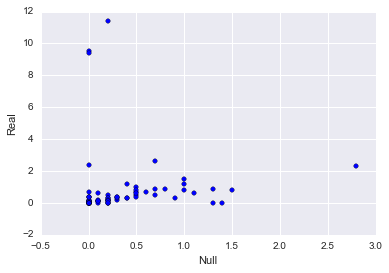

In [30]:
plt.scatter(null * 100000, real * 100000)
plt.xlabel('Null')
plt.ylabel('Real');

In [90]:
sns.set_style('whitegrid')

In [93]:
a.shape

(86, 31)

In [95]:
b.shape

(220, 31)

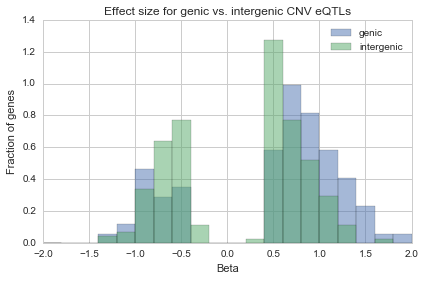

In [98]:
tdf = cnv_gv.sort_values(by=['cnv_overlaps_gene', 'pvalue'], 
                         ascending=[False, True]).drop_duplicates(subset=['gene_id'])
a = tdf[tdf.cnv_overlaps_gene]
b = tdf[tdf.cnv_overlaps_gene == False]
a.beta.hist(alpha=0.5, bins=np.arange(-2, 2.2, 0.2), normed=True, label='genic')
b.beta.hist(alpha=0.5, bins=np.arange(-2, 2.2, 0.2), normed=True, label='intergenic')
plt.title('Effect size for genic vs. intergenic CNV eQTLs')
plt.ylabel('Fraction of genes')
plt.xlabel('Beta')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'genic_vs_intergenic_beta.pdf'))

In [32]:
overlaps_sig = len(sig_intergenic_cnvs & overlaps_gene)
overlaps_not_sig = len(not_sig_cnvs & overlaps_gene)
no_overlaps_sig = len(sig_intergenic_cnvs) - overlaps_sig
no_overlaps_not_sig = len(not_sig_cnvs) - overlaps_not_sig
ctable = [[overlaps_sig, overlaps_not_sig], 
          [no_overlaps_sig, no_overlaps_not_sig]]
odds,p = stats.fisher_exact(ctable)
print('CNVs with significant association are enriched for '
      'overlapping a gene p={:.1e}'.format(p))

CNVs with significant association are enriched for overlapping a gene p=1.2e-08


While these CNVs don't overlap the gene that they are an eQTL for, they are still
enriched for overlapping some other gene.

In [33]:
odds = []
pvalues = []
for c in roadmap_overlap.columns:
    vc = (roadmap_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (roadmap_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
roadmap_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=roadmap_overlap.columns)
colors = pd.DataFrame(zip(list(set([x.split('_')[-1] for x in roadmap_res.index])), 
                          cpb.analysis.tableau20[::2]), columns=['mark', 'color'])
roadmap_res['mark'] = [x.split('_')[-1] for x in roadmap_res.index]
roadmap_res['ind'] = roadmap_res.index
roadmap_res = roadmap_res.merge(colors)
roadmap_res.index = roadmap_res.ind

TODO: limit to insignificant intergenic CNVs.

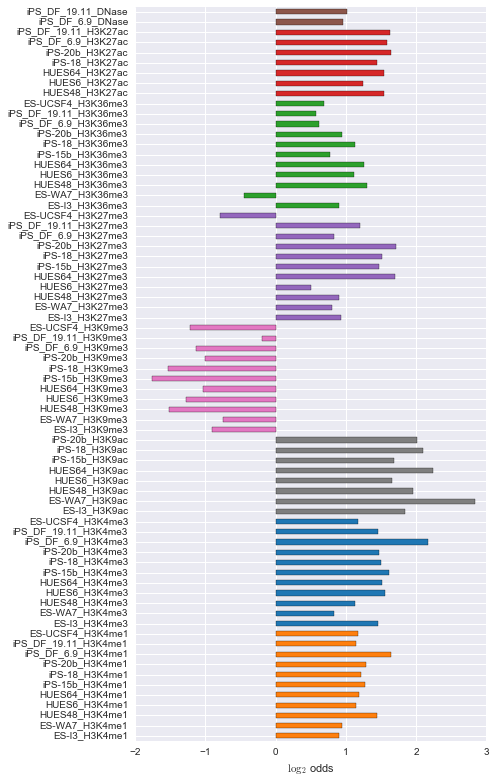

In [49]:
plt.figure(figsize=(7, 11))
(np.log2(roadmap_res.odds)).plot(kind='barh', color=roadmap_res.color)
plt.tight_layout()
plt.xlabel('$\log_2$ odds')
plt.ylabel('')
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'intergenic_histone_mark_odds.pdf'))

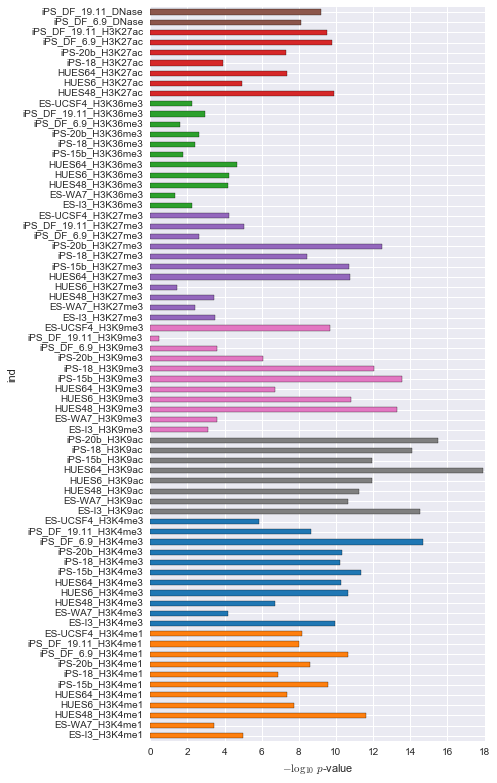

In [50]:
plt.figure(figsize=(7, 11))
(-np.log10(roadmap_res.pvalue)).plot(kind='barh', color=roadmap_res.color)
plt.xlabel('$-\log_{10}$ $p$-value')
plt.tight_layout()

In [36]:
odds = []
pvalues = []
for c in encode_dnase_overlap.columns:
    vc = (encode_dnase_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_dnase_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_dnase_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_dnase_overlap.columns)

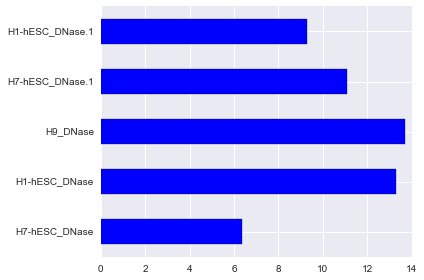

In [37]:
(-np.log10(encode_dnase_res.pvalue)).plot(kind='barh')
plt.tight_layout()

In [38]:
odds = []
pvalues = []
for c in encode_chip_overlap.columns:
    vc = (encode_chip_overlap.ix[sig_intergenic_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        sig_overlap = 0
    else:
        sig_overlap = vc[True]
    sig_not_overlap = vc[False]
    vc = (encode_chip_overlap.ix[not_sig_cnvs, c] > 0).value_counts()
    if True not in vc.index:
        not_sig_overlap = 0
    else:
        not_sig_overlap = vc[True]
    not_sig_not_overlap = vc[False]
    ctable = [[sig_overlap, sig_not_overlap], 
              [not_sig_overlap, not_sig_not_overlap]]
    o,p = stats.fisher_exact(ctable)
    odds.append(o)
    pvalues.append(p)
encode_chip_res = pd.DataFrame({'odds':odds, 'pvalue':pvalues}, index=encode_chip_overlap.columns)
encode_chip_res.sort_values(by='pvalue', inplace=True, ascending=False)

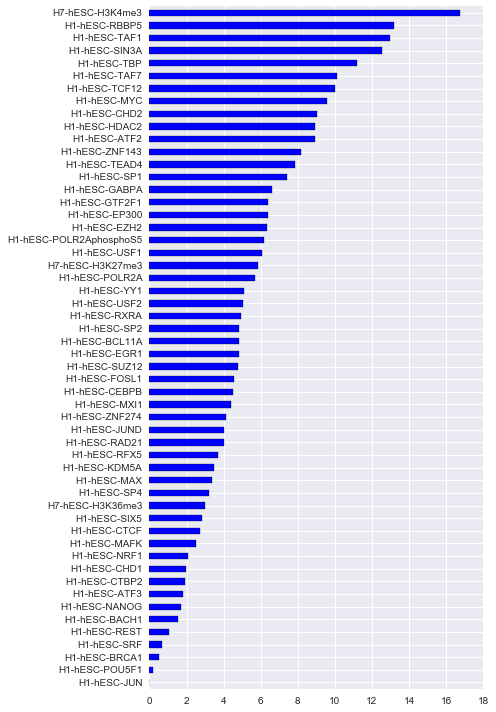

In [39]:
plt.figure(figsize=(7, 10))
(-np.log10(encode_chip_res.pvalue)).plot(kind='barh')
plt.tight_layout()

In [61]:
cnv_lead_vars['overlaps_gene'] = cnv_gv.ix[cnv_lead_vars.index, 'cnv_overlaps_gene']

In [ ]:
cnv_gv.ix['chr4:35240270-35244303:ENSG00000047365.7']

In [65]:
cnv_lead_vars.overlaps_gene

chr1:1637041-1638870:ENSG00000008128.18          True
chr4:35240270-35244303:ENSG00000047365.7          NaN
chr14:102637314-102639701:ENSG00000080824.14    False
chr1:16365505-16370349:ENSG00000080947.10         NaN
chr5:140222275-140228275:ENSG00000081842.13      True
chr1:108733342-108737242:ENSG00000085491.11      True
chr19:54728630-54736752:ENSG00000088038.13        NaN
chr19:54739008-54743710:ENSG00000088038.13        NaN
chr22:24325333-24331991:ENSG00000099991.12      False
chr22:24325333-24331991:ENSG00000099994.10      False
chr16:22599531-22603212:ENSG00000103404.10        NaN
chr11:17209714-17211214:ENSG00000110700.2         NaN
chr3:136021100-136026184:ENSG00000114054.9       True
chr6:132106570-132108770:ENSG00000118523.5      False
chr17:44327151-44330822:ENSG00000120071.8       False
chr1:147992889-147995447:ENSG00000122497.13     False
chr19:46817428-46818728:ENSG00000124440.11       True
chr7:75664281-75667842:ENSG00000127952.12        True
chr1:110230084-110232621:ENS

In [64]:
g = cnv_lead_vars.ix[cnv_lead_vars.overlaps_gene, 'gene_id']

ValueError: cannot index with vector containing NA / NaN values

In [62]:
cnv_lead_vars.shape

(158, 30)

In [ ]:
2 +

## Rare CNVs

In [ ]:
fn = os.path.join(ciepy.root, 'output/cnv_processing/cnv_info.tsv')
cnv_info = pd.read_table(fn, index_col=0)

In [ ]:
se = cnv_info.ix[set(cnv_gv.cnv_id), 'unrelated_percent_diff_from_mode']

In [ ]:
se[se < 0.01]

In [ ]:
cnv_info.percent_diff_from_mode[se[se < 0.05].index]

In [ ]:
cnv_info.ix['CNV_2_230877094_230879627']

In [ ]:
cnv_info_f = cnv_info[cnv_info.diff_from_mode != 0]

In [ ]:
fams = [
    'abb401f1-5c3e-48ed-8c55-839ce2afe7e6_14_diff_from_mode',
    '84fda65d-9a06-4bbe-ad75-a24773724c32_11_diff_from_mode',
    'a56f620d-82e4-4963-a80b-b97c091c4b06_9_diff_from_mode',
    '319aca18-4ca4-444d-80ca-3c0065169793_5_diff_from_mode',
    'cec0061a-f86c-4d8f-979f-3c6edce2d905_5_diff_from_mode',
    '0a78a1f4-540f-4f63-acd1-197228abad11_5_diff_from_mode',
    '24bb1db3-75fb-4c66-9ccd-8e98dc3fadf1_5_diff_from_mode',
    ]
for fam in fams:
    se = cnv_info_f.diff_from_mode == cnv_info_f[c]
    print(se[se])

In [ ]:
cnv_info.diff_from_mode.value_counts()

In [ ]:
se

In [ ]:
cnv_info.ix['CNV_1_144589274_144598121']

In [ ]:
se[se]